In [569]:
import numpy as np
from matplotlib import pyplot as plt
import astropy.constants as con
import astropy.units as u
from astropy.time import Time
import scipy
from scipy.signal import argrelmin
# import ugradio

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 17
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.axisbelow'] = True

In [584]:
def pow_fft(arr):
    return np.fft.fftshift(np.abs(np.fft.fft(arr))**2)

def freq(arr, dt):
    return np.fft.fftshift(np.fft.fftfreq(len(arr), dt))

## Loading data

In [585]:
sun_data, sun_times = np.load('sun_6hr_again.npy')

## Correcting Underlying Behavior

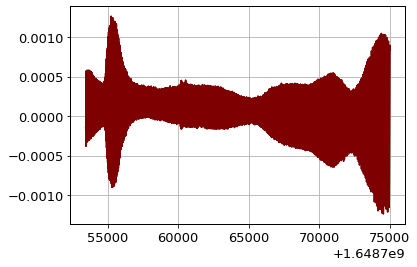

In [586]:
plt.plot(sun_times, sun_data, c='k')

# making a cut in the data because after a certain point it looks bad
# cut_index = -1
# sun_times_cut, sun_data_cut = sun_times[:cut_index], sun_data[:cut_index]
sun_times_cut, sun_data_cut = sun_times, sun_data
plt.plot(sun_times_cut, sun_data_cut, alpha=0.5, c='r')

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


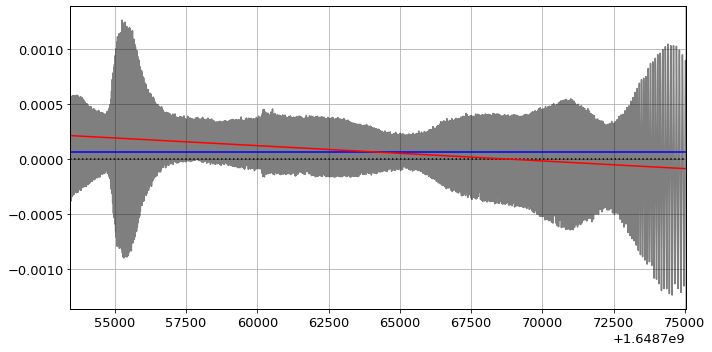

In [587]:
# trying to get it to lie at zero

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.axhline(0, c='k', linestyle='dotted')
ax.set_xlim(min(sun_times_cut), max(sun_times_cut))
ax.plot(sun_times_cut, sun_data_cut, alpha=0.5, c='k')

# # subtract off median
# median = np.median(sun_times_cut)
# plt.plot(sun_times_cut-median, sun_data_cut, alpha=0.5)

# subtract off mean
mean = np.mean(sun_data_cut)
ax.axhline(mean, c='b')

# poly fit, for every chunk calc mean and fit to that
p1 = np.polyfit(sun_times_cut, sun_data_cut, deg=1)
p2 = np.polyfit(sun_times_cut, sun_data_cut, deg=2)
p3 = np.polyfit(sun_times_cut, sun_data_cut, deg=3)


def use_polyfit(x, *p):
    coeff_num = len(p[0])
    p = p[0]
    if coeff_num == 2: # deg 1
        return p[0]*x + p[1]
    elif coeff_num == 3: # deg 2
        return p[0]*x**2 + p[1]*x + p[2]
    elif coeff_num == 4: # deg 3
        return p[0]*x**3 + p[1]*x**2 + p[2]*x + p[3]
    elif coeff_num == 5: # deg 3
        return p[0]*x**4 + p[1]*x**3 + p[2]*x**2 + p[3]*x + p[4]

y1 = np.polyval(p1, sun_times_cut)
ax.plot(sun_times_cut, y1, c='r')

# y2 = use_polyfit(sun_times_cut, p2)
# ax.plot(sun_times_cut, y2)

# y3 = use_polyfit(sun_times_cut, p3)
# ax.plot(sun_times_cut, y3)

# RESIDUAL PLOT
# ax[1].set_xlim(min(sun_times_cut), max(sun_times_cut))
# ax[1].plot(sun_times_cut, sun_data_cut, alpha=0.5, c='k')
# ax[1].plot(sun_times_cut, sun_data_cut - mean)
# ax[1].plot(sun_times_cut, sun_data_cut - y1)
# ax[1].plot(sun_times_cut, sun_data_cut - y2)
# ax[1].plot(sun_times_cut, sun_data_cut - y3)

plt.tight_layout()

In [588]:
# # SEPERATE DATA INTO SMALL CHUNKS AND CALCULATE MEAN OVER EACH CHUNK
# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# num_data_in_chunk = 40

# chunks = len(sun_times_cut)/num_data_in_chunk

# split_data = np.split(sun_data_cut, chunks)
# split_data_mean = np.mean(split_data, axis=1) # mean for each data chunk
# split_data_std = np.std(split_data, axis=1)

# print(len(split_data_mean))

# split_times = np.split(sun_times_cut, chunks)
# split_times_middle = np.mean(split_times, axis=1) # get center of each chunk?

# ax.scatter(split_times_middle, split_data_mean, zorder=1, c='r', s=3)
# ax.errorbar(split_times_middle, split_data_mean, split_data_std, linestyle='none', c='r')

# ax.set_xlim(min(sun_times_cut), max(sun_times_cut))
# ax.set_ylim(min(sun_data_cut)-0.00005, max(sun_data_cut)+0.00005)
# ax.plot(sun_times_cut, sun_data_cut, alpha=0.5, c='k', zorder=0)

In [589]:
# sub_split_data = []
# for i in range(len(split_data)):
#     val = split_data[i] - split_data_mean[i]
#     sub_split_data.append(val)
# sub_split_data = np.array(sub_split_data)

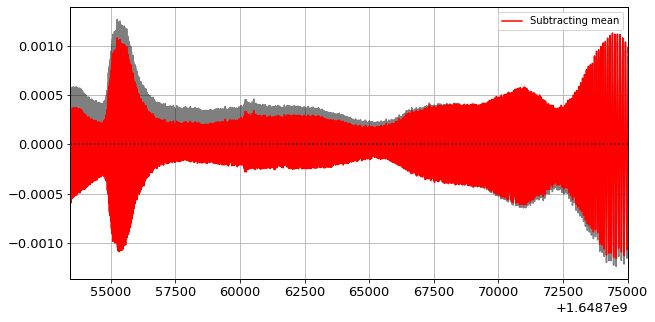

In [590]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_xlim(min(sun_times_cut), max(sun_times_cut))

ax.plot(sun_times_cut, sun_data_cut, alpha=0.5, c='k')
# ax.plot(sun_times_cut, sub_split_data.reshape(13500, -1), c='r', label='chunky mean')
ax.plot(sun_times_cut, sun_data_cut - y1, c='r', label='Subtracting mean')
# ax.plot(sun_times_cut, sun_data_cut - mean, c='b', label='overall mean')

ax.axhline(0, c='k', linestyle='dotted')

ax.legend()

apply 1st degree fit!

In [591]:
sun_data_cut = sun_data_cut - y1

## Solar Flare??

In [598]:
t = Time(sun_times_cut[0], format='jd')
print(sun_times_cut[0])
t_utc = t.iso
print(t_utc)
# plt.plot(t_utc.value, sun_data_cut, c='k')

1648753445.4026296


ErfaError: ERFA function "d2dtf" yielded 1 of "unacceptable date (Note 6)"

## Finding Fringe Freqs

In [496]:
def do_data_split(data, time, num_splits):
    n = len(data)
    split_size = n // num_splits
    data_splits = []
    freq_splits = []
    times_splits = [] # center of each chunk
    
    for i in range(num_splits):
        data_frac = data[i*split_size:(i+1)*split_size]
        time_frac = time[i*split_size:(i+1)*split_size]
        
        time_center = time_frac[len(time_frac)//2]
        dt = np.mean(np.diff(time_frac))
        frequency = freq(time_frac, dt)
        pow_frac = pow_fft(data_frac)
        
        data_splits.append(pow_frac)
        freq_splits.append(frequency)
        times_splits.append(time_center)
        
    return data_splits, freq_splits, times_splits

In [497]:
split_power, split_freqs, split_times = do_data_split(sun_data_cut, sun_times_cut, 24)

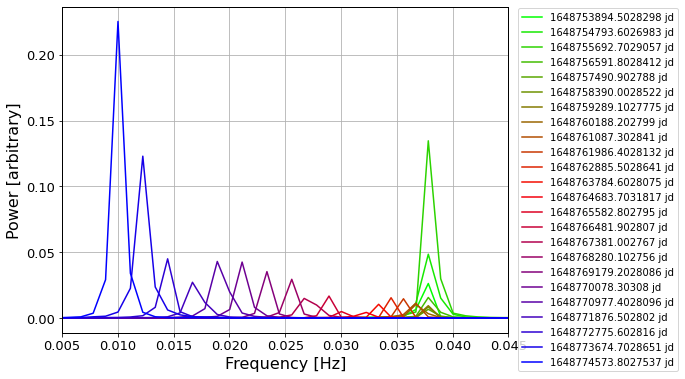

In [498]:
cmap = plt.cm.brg_r
n = len(split_power)
colors = cmap(np.linspace(0,1,n))

fig, ax = plt.subplots(1,1, figsize=(8,6))
# plt.title('Power spectrum of 6hr Sun observation\nsplit into {0:.0f} equal chunks'.format(len(split_power)))

# labels = []
# for i in range(len(split_power)):
#     label = '{0:.0f}/{1:.0f}'.format(i+1, len(split_power))
#     labels.append(label)

for i in range(len(split_power)):
    ax.plot(split_freqs[i], split_power[i], color=colors[i], label='{} jd'.format(split_times[i]))
    
# norm_scaling = mpl.colors.Normalize(vmin=min(range(len(split_power)))+1, vmax=max(range(len(split_power)))+1)
# divider = axgrid.make_axes_locatable(ax)
# cax = divider.append_axes("right", size='5%', pad=0.05)
# cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm_scaling, cmap=cmap), cax=cax)
# cbar.set_label(label= 'Chunk (N/{0:.0f})'.format(len(split_power)), rotation=270, labelpad=30)

    
plt.legend(bbox_to_anchor=(1.01,1.01), loc='upper left')
# plt.yscale('log')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Power [arbitrary]')
ax.set_xlim(0.005, 0.045)
# plt.ylim(0, 0.1)
plt.show()

(-0.05, 0.05)

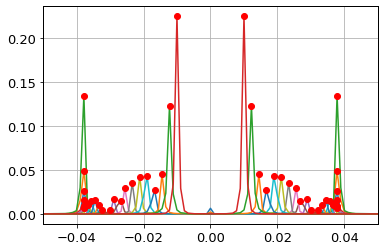

In [499]:
all_power_peaks = []
all_freqs_peaks = []
all_times_peaks = []

for i in range(len(split_freqs)):
    plt.plot(split_freqs[i], split_power[i])
    peak_i = scipy.signal.find_peaks(split_power[i], height = max(split_power[i])-max(split_power[i])/10)[0]
    
    keep_i = np.where(abs(split_freqs[i][peak_i]) > 0.005)
    peak_i = peak_i[keep_i]

    peak_power = split_power[i][peak_i]
    peak_freqs = split_freqs[i][peak_i]
    
    all_power_peaks.append(peak_power)
    all_freqs_peaks.append(peak_freqs)
    
    peak_times = []
    for n in range(len(peak_freqs)):
        peak_times.append(split_times[i])
        
    all_times_peaks.append(peak_times)

    plt.scatter(peak_freqs, peak_power, c='r', zorder=5)
    
plt.xlim(-0.05, 0.05)

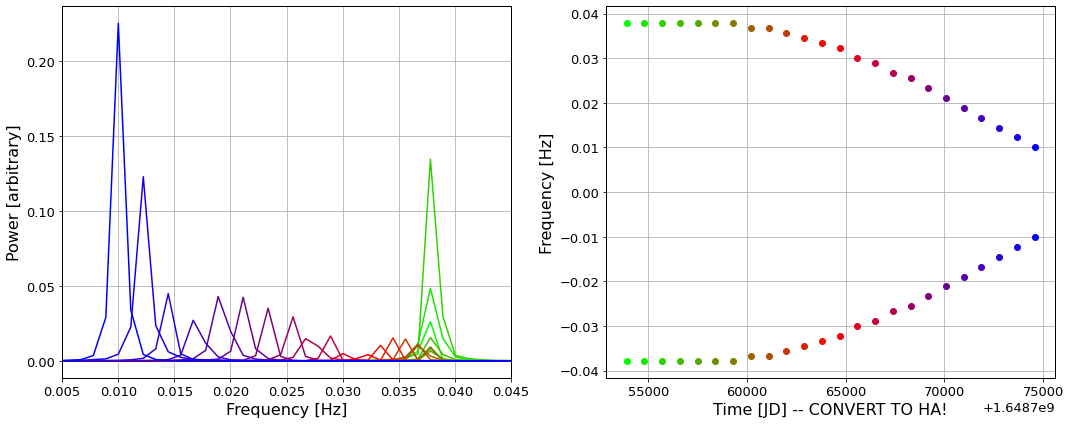

In [502]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))

cmap = plt.cm.brg_r
n = len(split_power)
colors = cmap(np.linspace(0,1,n))

for i in range(len(split_power)):
    ax[0].plot(split_freqs[i], split_power[i], color=colors[i], label='{} jd'.format(split_times[i]))
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_ylabel('Power [arbitrary]')
ax[0].set_xlim(0.005, 0.045)

    
for i in range(len(all_times_peaks)):
    ax[1].scatter(all_times_peaks[i], all_freqs_peaks[i], color=colors[i])
ax[1].set_xlabel('Time [JD] -- CONVERT TO HA!')
ax[1].set_ylabel('Frequency [Hz]')
    
plt.tight_layout()

Chi^2 = 2.81


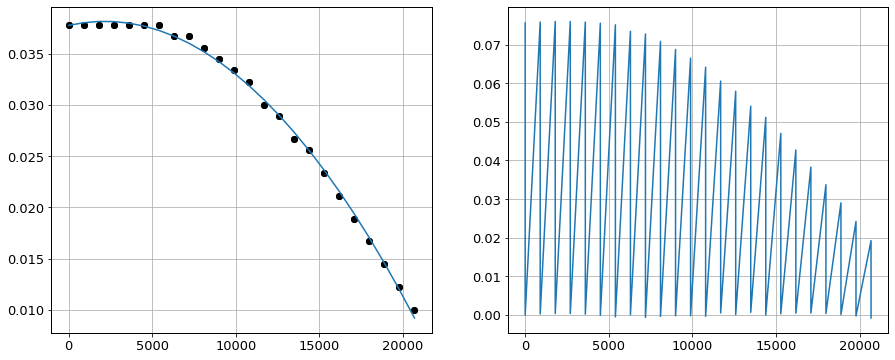

In [567]:
# fitting to how finge frequency changes
fig, ax = plt.subplots(1, 2, figsize=(15,6))

for i in range(len(all_times_peaks)):
    ax[0].scatter(all_times_peaks[i], abs(all_freqs_peaks[i]), color='k')
    # error are some fraction of peak width??
    
all_freqs_peaks = np.array(all_freqs_peaks).flatten()
all_times_peaks = np.array(all_times_peaks).flatten() - all_times_peaks[0]
    
p2 = np.polyfit(all_times_peaks, abs(all_freqs_peaks), deg=2)
y2 = np.polyval(p2, all_times_peaks)
ax[0].plot(all_times_peaks, y2)

r = y2 - all_freqs_peaks

chi2 = scipy.stats.chisquare(all_freqs_peaks, y2, ddof=3)
print('Chi^2 = {:.3}'.format(chi2[0]))
ax[1].plot(all_times_peaks, r)


## Fitting Bessel Function

In [268]:
# first we have to fft to get rid of low frequencyies (oscillations within the envelope)

In [286]:
x = np.linspace(0.01,15,10000)
j1 = scipy.special.j1(x)

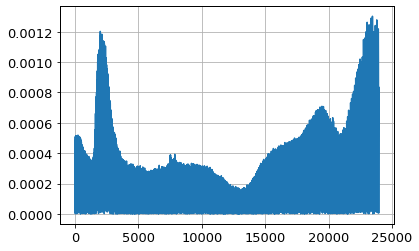

In [287]:
abs_data = np.abs(sun_data_cut - mean)
plt.plot(abs_data)

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


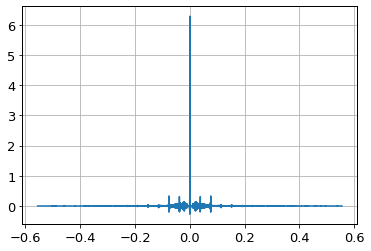

In [288]:
fft = np.fft.fftshift(np.fft.fft(abs_data))
freqs = freq(sun_times_cut, np.mean(np.diff(sun_times_cut)))
plt.plot(freqs, fft)
# plt.ylim(0,.2)
# plt.xlim(-0.1, 0.1)

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


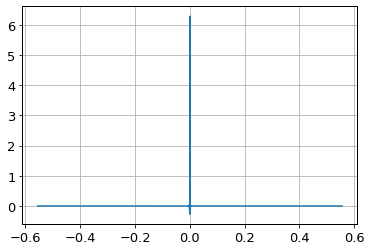

In [289]:
fft[np.where(freqs > 0.003)] = 0
fft[np.where(freqs < -0.003)] = 0
plt.plot(freqs, fft)

(1648753445.4026296, 1648775028.3027585)

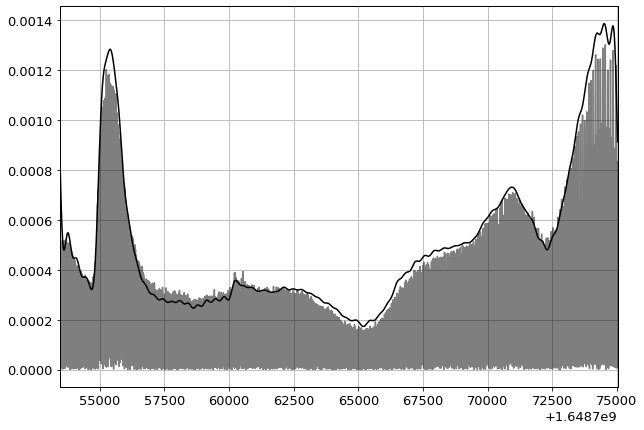

In [319]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
filtered_sun_data = np.fft.ifft(fft)

amp = 1.9
centered_abs_filtered = amp*np.abs(filtered_sun_data - np.mean(filtered_sun_data))

ax.plot(sun_times_cut, centered_abs_filtered, c='k')
ax.plot(sun_times_cut, abs_data, c='k', alpha=0.5)

index = scipy.signal.argrelmin(centered_abs_filtered, order=2000)

minima = sun_times_cut[index]

# for i in minima:
#     ax.axvline(i, c='r', linestyle='--')
    
ax.set_xlim(min(sun_times_cut), max(sun_times_cut))

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


(1648753445.4026296, 1648775028.3027585)

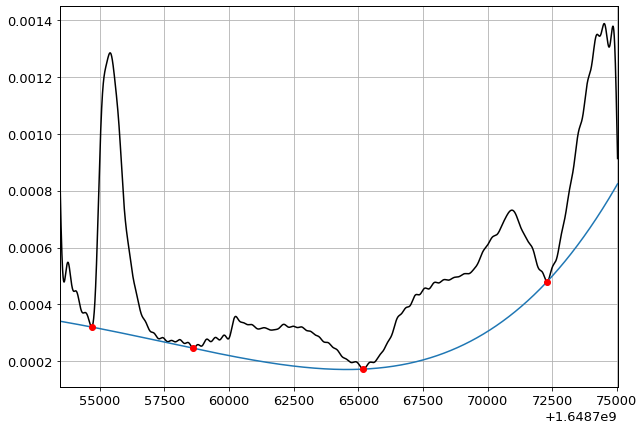

In [320]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

minima = sun_times_cut[index] - sun_times_cut[0]
minima_data = centered_abs_filtered[index]

ax.plot(sun_times_cut, centered_abs_filtered, c='k')
ax.scatter(minima + sun_times_cut[0], minima_data, c='r', zorder=5)

# p1 = np.polyfit(minima, minima_data, deg=1)
# y1 = np.polyval(p1, sun_times_cut - sun_times_cut[0])
# plt.plot(sun_times_cut, y1)

p2 = np.polyfit(minima, minima_data, deg=4)
y2 = np.polyval(p2, sun_times_cut - sun_times_cut[0])
ax.plot(sun_times_cut, y2)

ax.set_xlim(min(sun_times_cut), max(sun_times_cut))

In [321]:
# minima = sun_times_cut[index]
# minima_data = centered_abs_filtered[index]

# plt.plot(sun_times_cut, centered_abs_filtered, c='k')
# plt.scatter(minima, minima_data, c='r', zorder=5)

# p_1 = np.polyfit(minima[:2], minima_data[:2], deg=1)
# y_1 = use_polyfit(sun_times_cut[(index[0][0]):(index[0][1])], p_1)
# plt.plot(sun_times_cut[(index[0][0]):(index[0][1])], y_1)

# p_2 = np.polyfit(minima[2:4], minima_data[2:4], deg=1)
# y_2 = use_polyfit(sun_times_cut[(index[0][1]):(index[0][2])], p_2)
# plt.plot(sun_times_cut[(index[0][1]):(index[0][2])], y_2)

# # p_2 = np.polyfit(minima[4:5], minima_data[4:5], deg=1)
# # y_2 = use_polyfit(sun_times_cut[(index[0][2]):(index[0][3])], p_2)
# # plt.plot(sun_times_cut[(index[0][2]):(index[0][3])], y_2)

# # p2 = np.polyfit(minima, minima_data, deg=2)
# # y2 = use_polyfit(sun_times_cut, p2)
# # plt.plot(sun_times_cut, y2)

(1648753445.4026296, 1648775028.3027585)

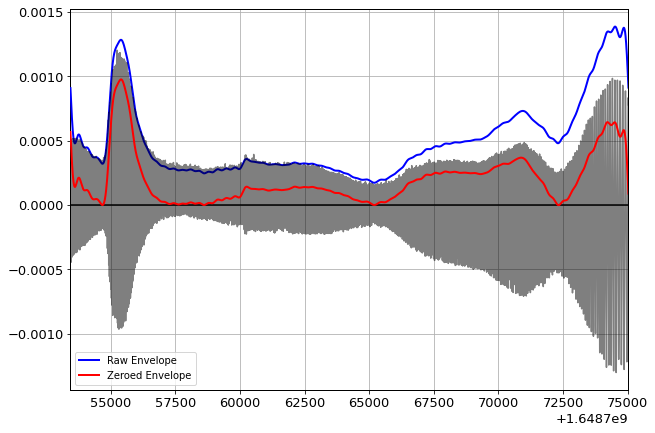

In [323]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
centered_abs_filtered[np.where((sun_times > minima[0]) & (sun_times < minima[1]))] *= -1
# centered_abs_filtered[np.where( (sun_times > minima[2]) & (sun_times < minima[3]) )] *= -1

# unabs_envelope = -centered_abs_filtered[np.where((sun_times > minima[0]))]
# unabs_envelope = -unabs_envelope[np.where((sun_times < minima[1]))]

ax.plot(sun_times_cut, centered_abs_filtered, c='b', zorder=5, linewidth=2, label='Raw Envelope') # envelope
# plt.plot(sun_times_cut, 2*centered_abs_filtered-y1, c='r', zorder=5) # fitted 1st and subtracted envelope
# plt.plot(sun_times_cut, 2*centered_abs_filtered-y2, c='orange', zorder=5) # fitted 2nd and subtracted envelope
ax.plot(sun_times_cut, (centered_abs_filtered - y2), c='r', zorder=6, linewidth=2, label='Zeroed Envelope')
ax.plot(sun_times_cut, sun_data_cut-mean, alpha=0.5, c='k', zorder=5) # data

ax.axhline(0, c='k')
ax.legend()

ax.set_xlim(min(sun_times_cut), max(sun_times_cut))

In [294]:
corrected_envelope = 1.5*(centered_abs_filtered - y2)

In [295]:
def bessel(ha, thetaR, A):
    delta = 0
    d = 14.7106 #m
    u = d * np.cos(delta) * np.cos(ha) / λ
    x = 2 * np.pi * thetaR * u
#     print("x", x[1])
    return A * scipy.special.j1(x) / x

In [296]:
val = con.c / (10.5e9 * u.Hz)
λ = val.to(u.m).value
# print("lambda", λ)

# L, long, alt_nch = ugradio.nch.lat, ugradio.nch.lon, ugradio.nch.alt 

# jds=ugradio.timing.julian_date(sun_times_cut)
# alpha,delta =ugradio.coord.sunpos(jds[0])
# delta=(np.pi/180)*delta
# LSTs = ugradio.timing.lst(jds,lon=long)
# hs = LSTs - alpha*(np.pi/180)
# # print(len(hs))
# ha = np.linspace(hs[0],(hs[0]+(15*6*0.4682857619762978)*(np.pi/180)),len(jds))
ha = np.load('ha_sun_6hr.npy')
ha_cut = ha[:cut_index]

p0 = [0.004, 0.005]
pars, cov = scipy.optimize.curve_fit(bessel, ha_cut[1000:-5000], corrected_envelope[1000:-5000], p0)

ValueError: operands could not be broadcast together with shapes (17963,) (17982,) 

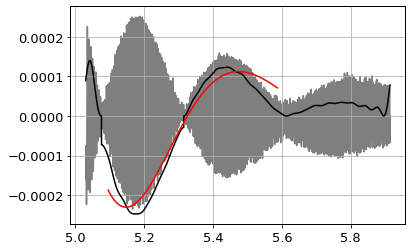

In [229]:
plt.plot(ha_cut[1000:-5000], bessel(ha_cut[1000:-5000], pars[0], pars[1]), c='r', zorder=5)
plt.plot(ha_cut, corrected_envelope, c='k')
plt.plot(ha_cut, sun_data_cut-mean, zorder=0, c='k', alpha=0.5)

ax.set_xlim(min(sun_times_cut), max(sun_times_cut))

In [230]:
pars[0] * 180/np.pi *2

0.4315607201026444